# Inference with Variational Autoencoder

In [71]:
# Load all related modules
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image

from torchvision import datasets
import torchvision.transforms as T

import res.viz_utils as vu

from res.plot_lib import plot_data, show_scatterplot, set_default

set_default()

In [72]:

DATA_DIR = "data"
MODEL_DIR = "models"


NUM_EPOCH = 30
BATCH_SIZE = 256
hidden_size = 20

mname = "vae"
model_path = os.path.join(MODEL_DIR, f"{mname}_mnist_z{hidden_size}_ep{NUM_EPOCH}.pth")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Load Dataset

In [73]:
# Load training and test data
img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=img_transform,
)

test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=img_transform,
)

# Create data loader
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

test_loader = DataLoader(
    test_data,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

[n, dx1, dx2] = train_data.data.size()

### Load model

In [74]:
# Define model architecture and loss function
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size ** 2),
            nn.Tanh(),
            nn.Linear(hidden_size ** 2, hidden_size * 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size ** 2),
            nn.Tanh(),
            nn.Linear(hidden_size ** 2, input_size),
            nn.Tanh(),
        )
    
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu
    
    def encode(self, x):
        mu_logvar = self.encoder(x)
        mu_logvar = mu_logvar.view(-1, 2, self.hidden_size)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        xr = self.decode(z)
        return xr, mu, logvar
    
def vae_loss(x_hat, x, mu, logvar, beta=1):
    rec_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    kl_loss = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    vae_loss = rec_loss + beta * kl_loss
    return vae_loss, rec_loss, kl_loss

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Tanh(),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

In [75]:
print(f"Using {DEVICE} device: {model_path}")

# Define loss function
criterion = vae_loss
beta = 1

# Define model
input_size = 28 * 28
model = VariationalAutoencoder(input_size, hidden_size).to(DEVICE)

model.load_state_dict(torch.load(model_path))
model.eval()

print(model)

Using cpu device: models/vae_mnist_z20_ep30.pth
VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Tanh()
  )
)


### Visualize Weights

img_np : 0.0 1.0


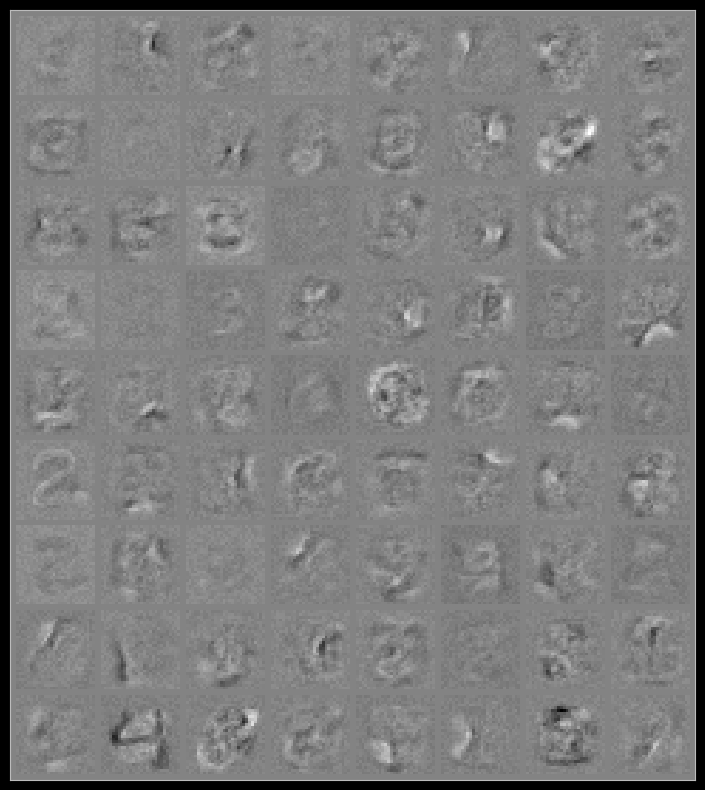

In [76]:
W = model.encoder[0].weight.view(-1, 1, dx1, dx2)

# Visualize training data
grid = vu.set_grid(W, num_cells=72)
vu.show(grid)


### Image Reconstruction

In [77]:
X, _ = next(iter(train_loader))
Xt, _ = next(iter(test_loader))

In [78]:
# Reconstruct images
model.eval()

with torch.no_grad():
    # Feedforward
    x = X.view(-1, input_size).to(DEVICE)
    xt = Xt.view(-1, input_size).to(DEVICE)

    x_rec, mu, logvar = model(x)
    xt_rec, mu_t, logvar_t = model(xt)

    X_rec = x_rec.view(-1, 1, dx1, dx2)
    Xt_rec = xt_rec.view(-1, 1, dx1, dx2)

    # # Compute loss
    # train_vae_loss, train_rec_loss, train_kl_loss = criterion(x_rec, x, mu, logvar, beta=beta)
    # test_vae_loss, test_rec_loss, test_kl_loss = criterion(xt_rec, xt, mu_t, logvar_t, beta=beta)

    # print(f"Train vae loss: {train_vae_loss.item():.4f}, rec loss: {train_rec_loss.item():.4f}, kl loss: {train_kl_loss.item():.4f}")
    # print(f"Test vae loss: {test_vae_loss.item():.4f}, rec loss: {test_rec_loss.item():.4f}, kl loss: {test_kl_loss.item():.4f}")

img_np : 0.0 1.0


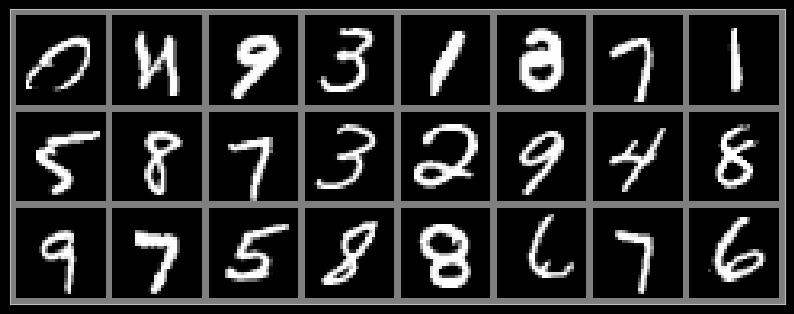

In [79]:
# Visualize training data
grid = vu.set_grid(X, num_cells=24)
vu.show(grid)

img_np : 0.0 1.0


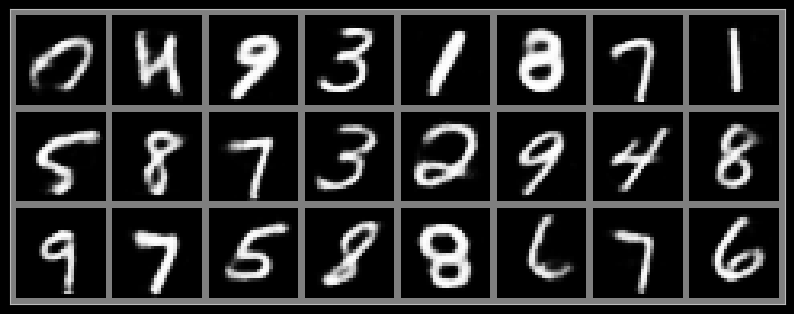

In [80]:
# Visualize training reconstruction
grid = vu.set_grid(X_rec, num_cells=24)
vu.show(grid)

img_np : 0.0 1.0


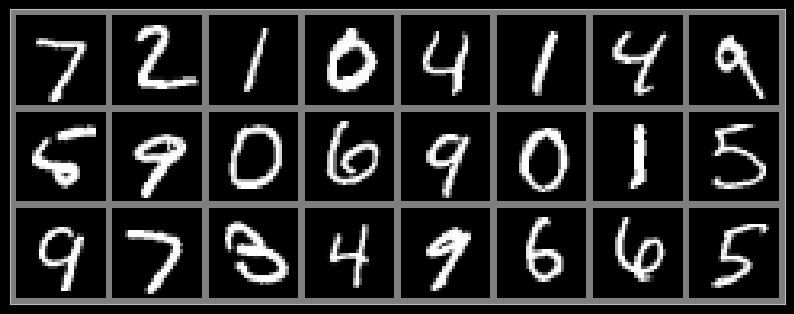

In [81]:
# Visualize test data
grid = vu.set_grid(Xt, num_cells=24)
vu.show(grid)

img_np : 0.0 1.0


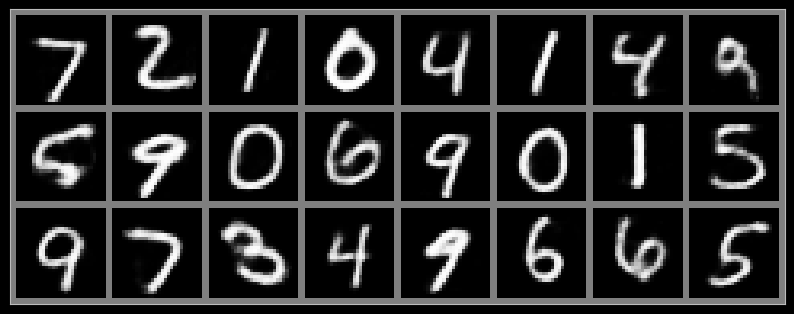

In [82]:
# Visualize test reconstruction
grid = vu.set_grid(Xt_rec, num_cells=24)
vu.show(grid)

### Generating a few random samples

torch.Size([16, 1, 28, 28])
img_np : 0.0 0.99999994


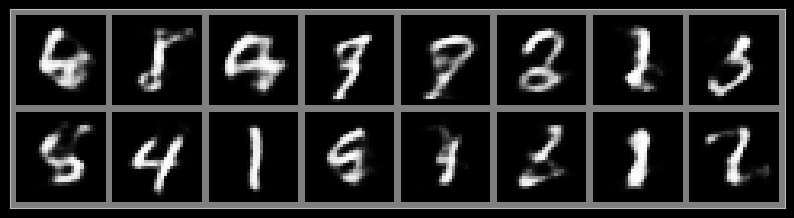

In [83]:
m = 16
z = torch.randn((m, hidden_size)).to(DEVICE) #latent variable z is generated randomly
sample = model.decode(z)

sample = sample.view(-1, 1, dx1, dx2)
print(sample.size())

grid = vu.set_grid(sample, num_cells=m)
vu.show(grid)

### Image Morphing

In [84]:
def morph(model, xs, xt, n_steps=5):
    """
    Args:
        model (nn.Module): AE model
        xs (torch.Tensor): source image vector
        xt (torch.Tensor): target image vector
        n_steps (int): number 
    
    """
    # Visualize inputs
    X_input = torch.stack([xs, xt], dim=0)
    X2d = X_input.reshape((-1, dx1, dx2))
    grid = vu.set_grid(X2d, num_cells=2)
    vu.show(grid)
    
    model.eval()

    with torch.no_grad():
        zs, _, _ = model.encode(xs)
        zt, _, _ = model.encode(xt)
    
    # Linear interpolate on Z codes
    t_list = np.linspace(0, 1, n_steps).tolist()
    z_list = []
    for t in t_list:
        z_list.append(torch.lerp(zs, zt, t))

    Zm = torch.stack(z_list, dim=0)

    # Decode morphed images
    Xm = model.decoder(Zm)
    
    # Visualize the morphed images
    X2d = Xm.reshape((-1, dx1, dx2))
    grid = vu.set_grid(X2d, num_cells=len(z_list))
    vu.show(grid)

img_np : 0.0 1.0
img_np : 0.0 1.0


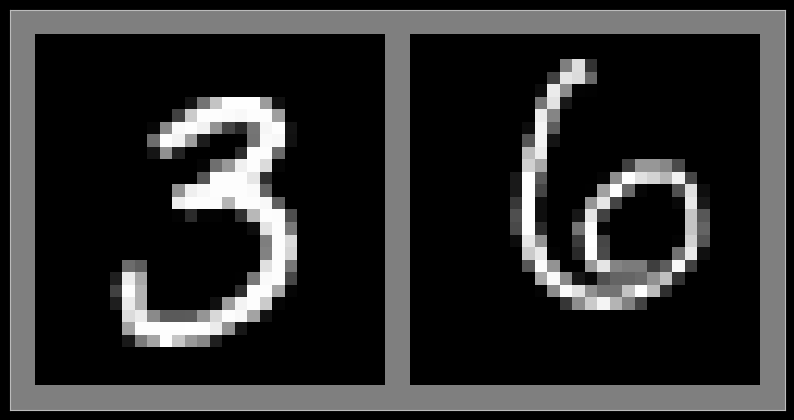

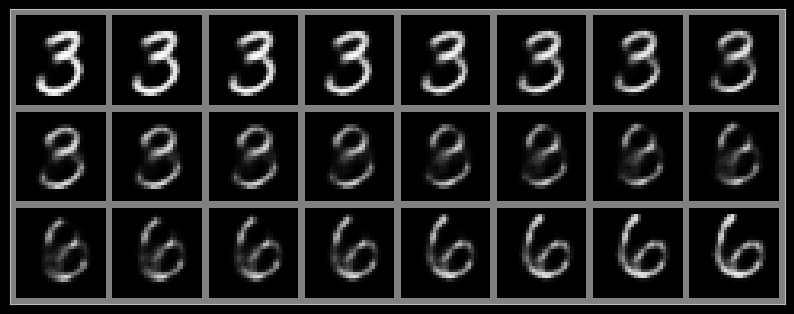

In [85]:
morph(model, Xt[90].view(input_size), Xt[100].view(input_size), n_steps=24)

### Latent Code Separation

1. Encode the input images into their corresponding latent codes
2. Reduce the dimensionality of the codes into 2-dim through manifold learning with tSNE
3. Visualize the 2-dim codes

In [86]:
from sklearn.manifold import TSNE

In [87]:
# Load models
model_ae = Autoencoder(input_size, 128).to(DEVICE)
model_ae.load_state_dict(torch.load(os.path.join(MODEL_DIR, "ae_mnist_z128_ep30.pth")))
model_ae.eval()

model_vae = VariationalAutoencoder(input_size, hidden_size).to(DEVICE)
model_vae.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"vae_mnist_z{hidden_size}_ep30.pth")))
model_vae.eval()

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Tanh()
  )
)

In [88]:
# Get all test codes
Zt_ae = []
Zt_vae = []
Yt = []
for batch_idx, (Xt, yt) in enumerate(test_loader):
    with torch.no_grad():
        zt_ae = model_ae.encoder(Xt.view(-1, input_size).to(DEVICE))
        zt_vae, _, _ = model_vae.encode(Xt.view(-1, input_size))
        zt_vae = zt_vae.to(DEVICE)
    
    Zt_ae.append(zt_ae)
    Zt_vae.append(zt_vae)
    Yt.append(yt)

    if batch_idx == 4:
        break
Zt_ae = torch.concatenate(Zt_ae, axis=0)
Zt_vae = torch.concatenate(Zt_vae, axis=0)
Yt = torch.concatenate(Yt, axis=0)
print(f'Zt_ae size: {Zt_ae.size()}')
print(f'Zt_vae size: {Zt_vae.size()}')
print(f'Yt size: {Yt.size()}')

Zt_ae size: torch.Size([1280, 128])
Zt_vae size: torch.Size([1280, 20])
Yt size: torch.Size([1280])


In [89]:
model_vae.training

False

In [90]:
# Train tSNE
tsne = TSNE(n_components=2, random_state=0)
Ct_ae = tsne.fit_transform(Zt_ae)
Ct_ae = torch.from_numpy(Ct_ae)

Ct_vae = tsne.fit_transform(Zt_vae)
Ct_vae = torch.from_numpy(Ct_vae)



/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mghifary/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


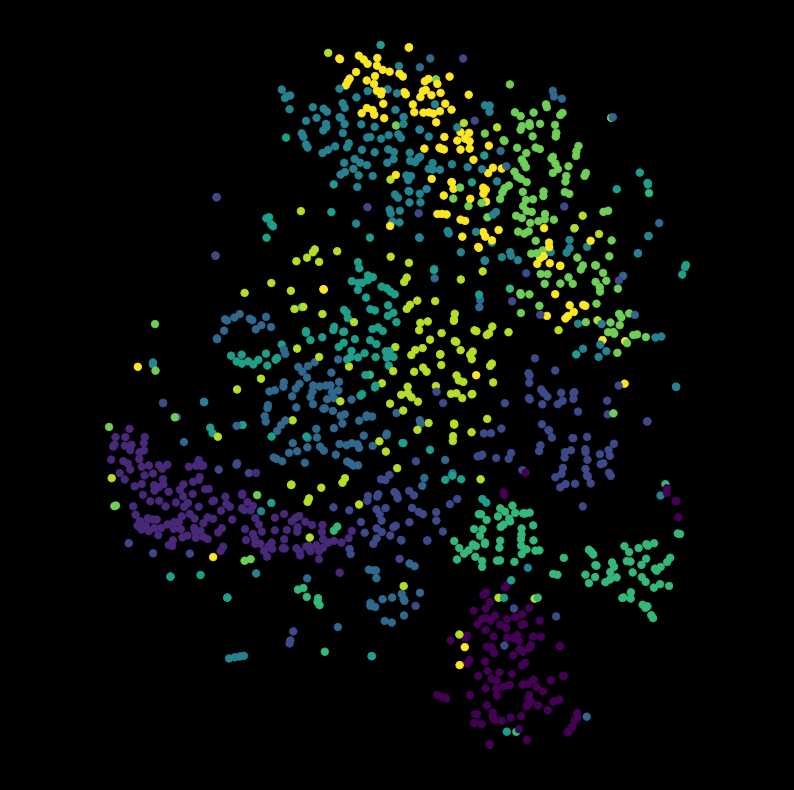

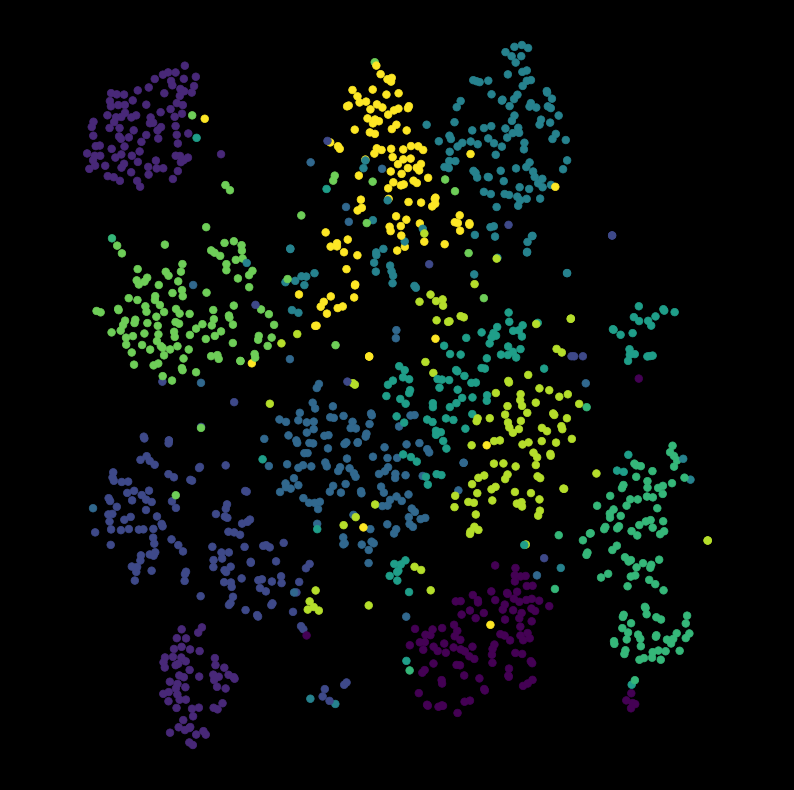

In [91]:
show_scatterplot(Ct_ae, Yt)
show_scatterplot(Ct_vae, Yt)

### Create Slider UI to Manipulate Latent Codes

In [92]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

In [93]:
def decode_and_display(model, zc):
    xc = model.decoder(zc)
    grid = vu.set_grid(torch.reshape(xc, (1, dx1, dx2)), num_cells=1)
    vu.show(grid)
    
def show_image(t):
    zc = Z_vae[t]
    decode_and_display(model, zc)

In [94]:
Zc = torch.clone(Z_vae)

In [95]:
zc = Zc[10]

zw_list = []
for i in range(20):
    zw_list.append(widgets.FloatSlider(min=-15, max=15, step=0.1, value=zc[i]))

l2 = int(len(zw_list) / 2)

ui1 = widgets.VBox(zw_list[:l2])
ui2 = widgets.VBox(zw_list[l2:])
ui = widgets.HBox([ui1, ui2])

In [96]:
def f(**kwargs):
    zc = torch.zeros(hidden_size)
    for key, val in kwargs.items():
        ikey = int(key)
        zc[ikey] = val
        
    decode_and_display(model, zc)

zcodes = {}
for i in range(len(zw_list)):
    key = str(i)
    zcodes[key] = zw_list[i]
out = widgets.interactive_output(f, zcodes)

display(ui, out)

Output()